In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import math
import pprint
from sklearn import preprocessing
import re

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download('punkt')
from nltk import word_tokenize

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattcirelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Update SIA with Loughran McDonald Dictionary

import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('stock_lex.csv')

stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

#update the positive and negative dictionaries
positive = []
reader = csv.reader('lm_positive.csv')
for row in reader:
    positive.append(row[0].strip())
    
negative = []
reader = csv.reader('lm_negative.csv')
for row in reader:
    entry = row[0].strip().split(" ")
    if len(entry) > 1:
        negative.extend(entry)
    else:
        negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [4]:
data = pd.read_csv('MSFT_news.csv')

In [5]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
0,0,NaN,nws_PQOjwL,2019-08-19 21:20:09+00:00,It's time to check out 3 tech stocks that came...,3 Tech Stocks for Growth Investors to Buy in A...,https://finance.yahoo.com/news/3-tech-stocks-g...
1,1,NaN,nws_LJWGLO,2019-08-19 20:35:46+00:00,How do you make sure a car is really safe to d...,Cybersecurity Stocks: Why Companies ‘Crash Tes...,https://finance.yahoo.com/news/cybersecurity-s...
2,2,NaN,nws_7KV5pl,2019-08-19 20:06:08+00:00,"Good news about tariffs on iPhone, iPads, Macs...","Apple Roundup: Tariffs, FAA, Russia, Music, Ap...",https://finance.yahoo.com/news/apple-roundup-t...
3,3,NaN,nws_ol3xpZ,2019-08-19 19:05:53+00:00,Microsoft Corporation (NASDAQ: MSFT) shares ha...,Large Microsoft Option Traders Selling Friday ...,https://finance.yahoo.com/news/large-microsoft...
4,4,NaN,nws_EbxeR1,2019-08-19 17:50:12+00:00,"If you want to invest with a clean conscience,...",5 Top ESG Stocks on RBC Capital&rsquo;s &lsquo...,https://finance.yahoo.com/news/5-top-esg-stock...


In [6]:
data['publication_date']=pd.to_datetime(data.publication_date,format='%Y-%m-%d')
data.index =data['publication_date']


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30200 entries, 2019-08-19 21:20:09 to 2016-04-22 01:05:08
Data columns (total 7 columns):
Unnamed: 0          30200 non-null int64
company             0 non-null float64
id                  30200 non-null object
publication_date    30200 non-null datetime64[ns]
summary             30180 non-null object
title               30200 non-null object
url                 30199 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.8+ MB


In [8]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-08-19 21:20:09,0,NaN,nws_PQOjwL,2019-08-19 21:20:09,It's time to check out 3 tech stocks that came...,3 Tech Stocks for Growth Investors to Buy in A...,https://finance.yahoo.com/news/3-tech-stocks-g...
2019-08-19 20:35:46,1,NaN,nws_LJWGLO,2019-08-19 20:35:46,How do you make sure a car is really safe to d...,Cybersecurity Stocks: Why Companies ‘Crash Tes...,https://finance.yahoo.com/news/cybersecurity-s...
2019-08-19 20:06:08,2,NaN,nws_7KV5pl,2019-08-19 20:06:08,"Good news about tariffs on iPhone, iPads, Macs...","Apple Roundup: Tariffs, FAA, Russia, Music, Ap...",https://finance.yahoo.com/news/apple-roundup-t...
2019-08-19 19:05:53,3,NaN,nws_ol3xpZ,2019-08-19 19:05:53,Microsoft Corporation (NASDAQ: MSFT) shares ha...,Large Microsoft Option Traders Selling Friday ...,https://finance.yahoo.com/news/large-microsoft...
2019-08-19 17:50:12,4,NaN,nws_EbxeR1,2019-08-19 17:50:12,"If you want to invest with a clean conscience,...",5 Top ESG Stocks on RBC Capital&rsquo;s &lsquo...,https://finance.yahoo.com/news/5-top-esg-stock...


In [9]:
str(data["summary"])

"publication_date\n2019-08-19 21:20:09    It's time to check out 3 tech stocks that came...\n2019-08-19 20:35:46    How do you make sure a car is really safe to d...\n2019-08-19 20:06:08    Good news about tariffs on iPhone, iPads, Macs...\n2019-08-19 19:05:53    Microsoft Corporation (NASDAQ: MSFT) shares ha...\n2019-08-19 17:50:12    If you want to invest with a clean conscience,...\n2019-08-19 17:05:34    Microsoft Corporation (NASDAQ: MSFT) shares ar...\n2019-08-19 16:38:32    Recessions in the semiconductor industry heark...\n2019-08-19 14:52:51    Two big events took place in July for investor...\n2019-08-19 14:45:42    Despite an initially negative response after e...\n2019-08-19 14:21:02    Alphabet's (GOOGL) Google launches iOS version...\n2019-08-19 13:50:00    Investing.com - Micron (NASDAQ:MU) led semicon...\n2019-08-19 13:19:01    Domestic firms seem to be gaining in this U.S....\n2019-08-19 13:14:01    Amazon's (AMZN) AWS is chosen by The Globe and...\n2019-08-19 13:05:46

In [10]:
#drop any duplicated headlines
data = data.sort_values(['summary']).drop_duplicates(subset='title')
data = data.sort_values(['publication_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'publication_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Concatenate all news into one
#data["summary"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

In [12]:
#Tokenize Words Data 
text=data["summary"][1]
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['Microsoft', 'revenue', ',', 'profit', 'misses', 'estimates']


In [13]:
##Tokenize Sentences Data
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['Microsoft revenue, profit misses estimates']


In [14]:
#Import English Stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'will', 'was', 'such', 'through', 'don', "needn't", 'few', 'off', 'do', 'why', 'o', 'out', "couldn't", "she's", "weren't", "won't", 'you', 'to', 'his', 'has', 'couldn', "wasn't", 'y', 'isn', 'nor', 'shan', 'am', 'own', 'how', 'your', 'of', 'at', 'that', 't', 'here', 'hers', 'each', 'm', 'most', 'needn', 'doing', 'be', 'not', 'now', 'were', 'a', 'any', 'hadn', 'd', 'with', 'in', 'some', 'for', 'have', 'yourselves', 'after', 'above', 'doesn', 'before', 'hasn', 'weren', 'if', 'i', 'those', 'mightn', 'there', "hasn't", 'these', "you're", 'does', 'ourselves', 'against', 'until', 'are', 've', 'on', 'from', 'below', 'once', 'should', "should've", 'because', "don't", 'who', 'mustn', 'shouldn', 'same', 'very', 'this', 'over', 'wasn', 'so', 'yours', "aren't", 'me', 'all', 'themselves', 'more', 'haven', 'didn', 'him', 'again', "shan't", 'just', 's', 'wouldn', 'she', 'them', 'only', 'we', 'yourself', 'while', 'is', 'further', "didn't", 'had', "isn't", 'other', 'ours', 'our', 'himself', 'he', 'whe

In [15]:
#Filter Stopwords
filtered_sent=[]
for w in tokenized_text:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['Microsoft revenue, profit misses estimates']
Filterd Sentence: ['Microsoft revenue, profit misses estimates']


https://github.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/blob/master/Predict_Dow_with_News.ipynb
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

# Clean the headlines
clean_headlines = []

for daily_headlines in data["summary"]:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [16]:
str(data["title"])

"publication_date\n2016-04-22 01:05:08    Intel and Microsoft face different challenges ...\n2016-04-22 02:18:28           Microsoft revenue, profit misses estimates\n2016-04-27 07:36:08        Is India ready for the 'thinnest' laptop age?\n2016-05-11 06:32:13    Are we ready for chatbots, the next technology...\n2016-05-25 21:13:59    Microsoft to cut 1,850 jobs at struggling smar...\n2016-05-30 07:50:04    Microsoft seeks to empower every Indian: Satya...\n2016-05-31 11:26:04    Newgen Software's unique app now on Windows pl...\n2016-06-13 10:12:03    Microsoft launches its online store with Tata ...\n2016-06-14 00:19:02    Microsoft to buy LinkedIn for $26.2 billion in...\n2016-06-16 22:22:43       Microsoft puts its cloud into cannabis startup\n2016-06-21 12:54:04    Edge is most power-efficient browser on Window...\n2016-06-22 12:26:04    Microsoft showcases SaaS cloud solutions in India\n2016-06-29 04:38:04    All may not be lost for struggling Nokia, Blac...\n2016-06-29 17:43:46

In [17]:
print(data["summary"])

publication_date
2016-04-22 01:05:08    Intel and Microsoft face different challenges ...
2016-04-22 02:18:28           Microsoft revenue, profit misses estimates
2016-04-27 07:36:08        Is India ready for the 'thinnest' laptop age?
2016-05-11 06:32:13    Are we ready for chatbots, the next technology...
2016-05-25 21:13:59    Microsoft to cut 1,850 jobs at struggling smar...
2016-05-30 07:50:04    Microsoft seeks to empower every Indian: Satya...
2016-05-31 11:26:04    Newgen Software's unique app now on Windows pl...
2016-06-13 10:12:03    Microsoft launches its online store with Tata ...
2016-06-14 00:19:02    Microsoft to buy LinkedIn for $26.2 billion in...
2016-06-16 22:22:43       Microsoft puts its cloud into cannabis startup
2016-06-21 12:54:04    Edge is most power-efficient browser on Window...
2016-06-22 12:26:04    Microsoft showcases SaaS cloud solutions in India
2016-06-29 04:38:04    All may not be lost for struggling Nokia, Blac...
2016-06-29 17:43:46         Window

### SIA compound score Calculation 
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/


In [18]:
sia = SIA()
results = []

for line in data["title"]:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.0772, 'headline': 'Intel and Microsoft face different challenges in shifts to cloud'}, {'neg': 0.244, 'neu': 0.385, 'pos': 0.372, 'compound': 0.25, 'headline': 'Microsoft revenue, profit misses estimates'}, {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.3612, 'headline': "Is India ready for the 'thinnest' laptop age?"}]


In [19]:
df123 = pd.DataFrame(results)
#df123['publication_date'] = data['publication_date']
#df123.Date = pd.to_datetime(df123.publication_date)
#df123.set_index('publication_date', inplace=True)
df123.head()

,compound,headline,neg,neu,pos
0,0.0772,Intel and Microsoft face different challenges ...,0.000,0.874,0.126
1,0.2500,"Microsoft revenue, profit misses estimates",0.244,0.385,0.372
2,0.3612,Is India ready for the 'thinnest' laptop age?,0.000,0.737,0.263
3,0.3612,"Are we ready for chatbots, the next technology...",0.000,0.762,0.238
4,-0.5994,"Microsoft to cut 1,850 jobs at struggling smar...",0.412,0.588,0.000


In [20]:
print(df123['headline'][1])

Microsoft revenue, profit misses estimates


In [21]:
df123.describe()

,compound,neg,neu,pos
count,23199.000000,23199.000000,23199.000000,23199.000000
mean,0.089681,0.045922,0.850367,0.103712
std,0.300819,0.105076,0.166099,0.142722
min,-0.908100,0.000000,0.141000,0.000000
25%,0.000000,0.000000,0.729000,0.000000
50%,0.000000,0.000000,0.866000,0.000000
75%,0.318200,0.000000,1.000000,0.208000
max,0.908100,0.713000,1.000000,0.859000


In [22]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23199 entries, 0 to 23198
Data columns (total 5 columns):
compound    23199 non-null float64
headline    23199 non-null object
neg         23199 non-null float64
neu         23199 non-null float64
pos         23199 non-null float64
dtypes: float64(4), object(1)
memory usage: 906.3+ KB


In [23]:
df123['label'] = 0
df123.loc[df123['compound'] > 0.1, 'label'] = 1
df123.loc[df123['compound'] < -0.1, 'label'] = -1
df123.head()

,compound,headline,neg,neu,pos,label
0,0.0772,Intel and Microsoft face different challenges ...,0.000,0.874,0.126,0
1,0.2500,"Microsoft revenue, profit misses estimates",0.244,0.385,0.372,1
2,0.3612,Is India ready for the 'thinnest' laptop age?,0.000,0.737,0.263,1
3,0.3612,"Are we ready for chatbots, the next technology...",0.000,0.762,0.238,1
4,-0.5994,"Microsoft to cut 1,850 jobs at struggling smar...",0.412,0.588,0.000,-1


In [24]:
print("Positive headlines:\n")
print(list(df123[df123['label'] == 1].headline)[:5])


Positive headlines:

['Microsoft revenue, profit misses estimates', "Is India ready for the 'thinnest' laptop age?", 'Are we ready for chatbots, the next technology wave?', 'Microsoft showcases SaaS cloud solutions in India', 'SoftwareONE recognized as Winner for 2016 Microsoft Volume Licensing Partner']


In [25]:
print("\nNegative headlines:\n")
print(list(df123[df123['label'] == -1].headline)[:5])


Negative headlines:

['Microsoft to cut 1,850 jobs at struggling smartphone unit', 'All may not be lost for struggling Nokia, BlackBerry', 'France orders Microsoft to stop collecting excessive user data', "Silicon Valley's Yahoo diaspora mourns company's decline", "The identity crisis that led to Yahoo's demise"]


In [26]:
print(df123.label.value_counts())

print(df123.label.value_counts(normalize=True) * 100)

 0    11652
 1     8237
-1     3310
Name: label, dtype: int64
 0    50.226303
 1    35.505841
-1    14.267856
Name: label, dtype: float64


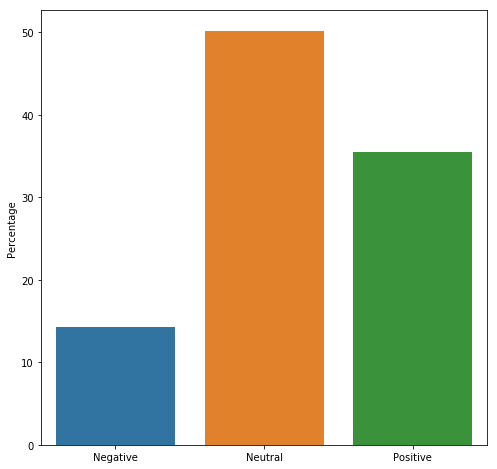

In [27]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))

counts = df123.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Count')

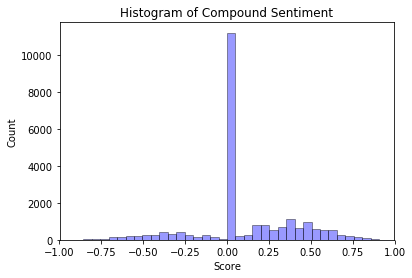

In [28]:

# seaborn histogram
sns.distplot(df123['compound'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Compound Sentiment')
plt.xlabel('Score')
plt.ylabel('Count')

In [29]:
#https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Generating%20Different%20Models.ipynb
#import numpy as np
#import pandas as pd
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#import nltk
#nltk.downloader.download('vader_lexicon')

#sentence = 'paris shootout police officer suspected guman dead'
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import unicodedata
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)
#ss

In [30]:
df123.index =data['publication_date']
df123.head()

,compound,headline,neg,neu,pos,label
publication_date,,,,,,
2016-04-22 01:05:08,0.0772,Intel and Microsoft face different challenges ...,0.000,0.874,0.126,0
2016-04-22 02:18:28,0.2500,"Microsoft revenue, profit misses estimates",0.244,0.385,0.372,1
2016-04-27 07:36:08,0.3612,Is India ready for the 'thinnest' laptop age?,0.000,0.737,0.263,1
2016-05-11 06:32:13,0.3612,"Are we ready for chatbots, the next technology...",0.000,0.762,0.238,1
2016-05-25 21:13:59,-0.5994,"Microsoft to cut 1,850 jobs at struggling smar...",0.412,0.588,0.000,-1


In [31]:
df123.to_csv('MSFT_sent_news.csv')